## Pendahuluan

SaaS (Software as a Service) adalah suatu layanan perangkat lunak berbasis awan yang memungkinkan pengguna jasa menggunakan suatu perangkat lunak dengan berlangganan. Dengan tidak mengunduh perangkat lunak, pengguna mengakses perangkat lunak tersebut melalui website penyedia.

### Pernyataan masalah

Untuk meningkatkan pelayanan, Amazon akan melihat statistik pembelian jasa SaaS selama periode 2020-2023. Hal ini dilakukan untuk menjaga kepercayaan klien serta memetakan performa setiap layanan yang diberikan. Sebagai seorang analis data, kita bertanya

Apa yang menjadi faktor pelanggan churn dari layanan SaaS Amazon?

Untuk mendalami tema tersebut, terdapat sejumlah pertanyaan lanjutan:

* Kapan user mulai berhenti membeli?
* Berapa value transaksi dari masing-masing cohort?
* Apakah cohort baru bertransaksi dengan value lebih besar atau kecil dibandingkan sebelumnya?
* Seberapa besar proporsi pelanggan yang berhenti membeli pada setiap bulannya?
* Seberapa besar Long Term Value user?
* Apakah profit berhubungan dengan diskon yang diberikan pada konsumen?
* Apa saja produk yang mengalami kerugian?


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from operator import attrgetter

In [27]:
pd.set_option('display.max_columns', None)


## Data 

Analisis ini akan menggunakan data 'SaaS-Sales.csv' yang dapat diunduh pada [link ini](https://drive.google.com/drive/folders/1dlpJfgvs8P_IyXqWB4WrNwk91fx0XAzU).

In [28]:
df_saas=pd.read_csv('SaaS-Sales.csv') 
df_saas.sample(3)

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
6495,6496,APJ-2023-111262,10/29/2023,20231029,Kimberly Newman,Japan,Tokyo,APJ,JAPN,Amazon,1004,Tech,SMB,Support,C6IVAC4YSE,15.552,3,0.2,5.4432
2509,2510,AMER-2023-163902,3/3/2023,20230303,Sam Alsop,United States,New York City,AMER,NAMER,Petrobras,1018,Energy,Strategic,Data Smasher,5EESMURCWU,479.940,6,0.0,52.7934
4461,4462,EMEA-2023-125717,9/29/2023,20230929,Sam Carr,Russia,Moscow,EMEA,EU-EAST,Walmart,1096,Retail,Enterprise,Data Smasher,8S6PVSQ8HQ,54.384,2,0.2,1.3596


## Data Understanding and Cleaning

Berdasarkan dokumentasi yang diberikan, data ini mengandung sejumlah kolom, di antaranya:

**Transaction**

1. Row ID: Nomor identifikasi unik setiap transaksi
2. Order ID: Nomor identifikasi unik setiap pesanan
3. Order Date: Tanggal pemesanan dilakukan 
4. Date Key: Representasi numerik tanggal pemesanan.

**Customer**

5. Contact Name: Nama orang yang melakukan pemesanan.
6. Country: Negara asal tempat pemesanan.
7. City: Kota asal tempat pemesanan.
8. Region: Region asal tempat pemesanan.
9. Subregion: Subregion asal tempat pemesanan.
10. Customer: Nama perusahaan yang melakukan pemesanan.
11. Customer ID: Nomor identifikasi unik setiap pemesan.
12. Industry: Rumpun industri pemesan.
13. Segment: Segmentasi pemesan.

**Product**

14. Product: Produk yang dipesan.
15. License: Kode lisensi yang melekat pada produk.
16. Sales: Total harga yang dibayarkan pemesan dalam transaksi.
17. Quantity: Kuantitas item yang dibeli dalam transaksi.
18. Discount: Diskon yang didapatkan pemesan dalam transaksi.
19. Profit: Keuntungan yang dihasilkan dalam transaksi.

Selanjutnya kita melihat isi dari masing-masing kolom dataset ini

In [29]:
listData= []
for col in df_saas.columns :
    listData.append( [col, df_saas.dtypes[col], df_saas[col].isna().sum(), df_saas[col].nunique(), df_saas[col].unique()])

tabelDesc = pd.DataFrame(columns=['Nama Kolom', 'Tipe Data','Missing Value','Jumlah Nilai Unik', 'Deskripsi Nilai Unik'],
                     data=listData)
print(df_saas.shape)

tabelDesc

(9994, 19)


,Nama Kolom,Tipe Data,Missing Value,Jumlah Nilai Unik,Deskripsi Nilai Unik
0,Row ID,int64,0,9994,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,Order ID,object,0,5009,"[EMEA-2022-152156, AMER-2022-138688, EMEA-2021..."
2,Order Date,object,0,1237,"[11/9/2022, 6/13/2022, 10/11/2021, 6/9/2020, 4..."
3,Date Key,int64,0,1237,"[20221109, 20220613, 20211011, 20200609, 20230..."
4,Contact Name,object,0,793,"[Nathan Bell, Deirdre Bailey, Zoe Hodges, Thom..."
5,Country,object,0,48,"[Ireland, United States, Germany, Sweden, Cana..."
6,City,object,0,262,"[Dublin, New York City, Stuttgart, Stockholm, ..."
7,Region,object,0,3,"[EMEA, AMER, APJ]"
8,Subregion,object,0,12,"[UKIR, NAMER, EU-WEST, NOR, JAPN, EU, MEA, LAT..."
9,Customer,object,0,99,"[Chevron, Phillips 66, Royal Dutch Shell, BNP ..."


Dari kedua rangkuman di atas, dapat diketahui bahwa:
1. Dataframe memiliki 19 kolom serta 9994 baris
2. Tidak terdapat nilai `na`, semua kolom tidak missing value
3. Kolom `Row ID` sebagai id unik transaksi tidak memiliki informasi relevan sehingga dapat dihapus saja. 
3. Kolom `Customer ID` sebagai id unik pelanggan yang memiliki jumlah data unik yang sama dengan nama pelanggan tidak memiliki informasi rbaru sehingga dapat dihapus saja. 
4. Dengan unique value sejumlah 5009, kolom `Order ID` mengindikasikan jumlah sebenarnya transaksi yang dilakukan. Kolom ini walau berstatus identifikasi tidak didrop
5. Kolom `Date Key` tidak memiliki informasi tambahan sehingga dapat dihapus saja
6. Kolom `License` sebagai id unik transaksi tidak memiliki informasi relevan sehingga dapat dihapus saja.
7. Kolom `Order Date` harus dikonversi menjadi datetime64 dan bisa digunakan untuk rujukan kolom berbasis tanggal lainnya

Selanjutnya, kita akan memilih fitur serta menambahkan fitur untuk menghasilkan dataframe baku untuk analisis


### Ubah Kolom order date menjadi datetime
Sesuai dengan pengamatan di atas, kita terlebih dahulu ubah tipe data kolom Order Date menjadi datetime64


In [30]:
saas=df_saas.copy()
saas['Order Date']=pd.to_datetime(saas['Order Date'])

### Tambahan Kolom Tanggal

Untuk melakukan analisis churn serta CLV, kita membutuhkan kolom yang mendeskripsikan bulan pertama transaksi pelanggan, bulan transaksi berlangsung, serta jeda waktu antara keduanya.
Ketiga value ini disimpan dalam kolom `cohort_month`, `current_order_month` dan `period_number`



In [31]:
# saas['day']=saas['Order Date'].dt.day
saas['month']=saas['Order Date'].dt.month
saas['year']=saas['Order Date'].dt.year

saas[['month','year']].sample(2)

,month,year
7562,9,2022
7770,8,2022


In [32]:
saas['current_order_month']=saas['Order Date'].dt.to_period('M')
saas['cohort_month']=saas.groupby('Customer ID')['Order Date'].transform('min').dt.to_period('M')
saas['period_number']=(saas.current_order_month-saas.cohort_month).apply(attrgetter('n'))

### Pemilihan fitur

Kolom yang didrop yaitu `Row ID`,`Date Key` serta `License`. Kita definisikan `saas` sebagai dataframe baru yang hanya memuat fitur terpilih

In [33]:
saas.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Date Key', 'Contact Name',
       'Country', 'City', 'Region', 'Subregion', 'Customer', 'Customer ID',
       'Industry', 'Segment', 'Product', 'License', 'Sales', 'Quantity',
       'Discount', 'Profit', 'month', 'year', 'current_order_month',
       'cohort_month', 'period_number'],
      dtype='object')

In [34]:
col=['Order ID', 'Order Date', 'Contact Name',
       'Country', 'City', 'Region', 'Subregion', 'Customer', 
       'Industry', 'Segment', 'Product', 'Sales', 'Quantity',
       'Discount', 'Profit', 'month', 'year', 'current_order_month',
       'cohort_month', 'period_number']
saas=saas[col]

### Clean Data

Melalui tiga proses di atas, kita akan mendapatkan dataframe bersih dengan deskripsi sebagai berikut:


In [35]:
listData= []
for col in saas.columns :
    listData.append( [col, saas.dtypes[col], saas[col].isna().sum(), saas[col].nunique(), saas[col].unique()])

tabelDesc = pd.DataFrame(columns=['Nama Kolom', 'Tipe Data','Missing Value','Jumlah Nilai Unik', 'Deskripsi Nilai Unik'],
                     data=listData)
print(saas.shape)
tabelDesc

(9994, 20)


,Nama Kolom,Tipe Data,Missing Value,Jumlah Nilai Unik,Deskripsi Nilai Unik
0,Order ID,object,0,5009,"[EMEA-2022-152156, AMER-2022-138688, EMEA-2021..."
1,Order Date,datetime64[ns],0,1237,"[2022-11-09 00:00:00, 2022-06-13 00:00:00, 202..."
2,Contact Name,object,0,793,"[Nathan Bell, Deirdre Bailey, Zoe Hodges, Thom..."
3,Country,object,0,48,"[Ireland, United States, Germany, Sweden, Cana..."
4,City,object,0,262,"[Dublin, New York City, Stuttgart, Stockholm, ..."
5,Region,object,0,3,"[EMEA, AMER, APJ]"
6,Subregion,object,0,12,"[UKIR, NAMER, EU-WEST, NOR, JAPN, EU, MEA, LAT..."
7,Customer,object,0,99,"[Chevron, Phillips 66, Royal Dutch Shell, BNP ..."
8,Industry,object,0,10,"[Energy, Finance, Tech, Healthcare, Manufactur..."
9,Segment,object,0,3,"[SMB, Strategic, Enterprise]"


Secara garis besar, dataframe kita kini memiliki 9994 baris dan 21 kolom, dari sebelumnya 9994 baris dan 21 kolom. Kita telah menghapus 4 kolom, namun menambahkan 6 kolom baru.

Simpan terlebih dahulu dataframe bersih ini dalam bentuk csv

In [36]:
from IPython.display import FileLink
saas.to_csv('saas_process.csv',index=True)

FileLink('saas_process.csv')

d:\Work\Purwadhika\Learn\Modul_2\saas_process.csv

### Data Analysis

Setelah mendapatkan dataframe yang sudah bersih, kita bisa mulai dengan menganalisa cohort pelanggan SaaS kita. Hal ini cukup terbantu dengan kolom `cohort_month` yang telah dibuat sebelumnya



#### Cohort Value

In [37]:
saas['cohort_month'].unique()

<PeriodArray>
['2020-02', '2020-03', '2020-01', '2020-04', '2020-09', '2020-05', '2020-06',
 '2020-08', '2020-07']
Length: 9, dtype: period[M]

Terdapat 10 cohort berdasarkan bulan pertama pelanggan mulai membeli langganan di SaaS kita. Cohort pertama masuk pada Januari 2020, sementara cohort terakhir masuk pada September 2020 Selanjutnya kita akan menjawab pertanyaan, berapa value transaksi dari masing-masing cohort?

In [38]:
a=saas.groupby(['cohort_month'])[['Sales']].sum().reset_index()
a.sort_values(by='Sales', ascending=False)

,cohort_month,Sales
0,2020-01,665369.8547
2,2020-03,649382.4826
1,2020-02,462481.2878
3,2020-04,225191.0912
5,2020-06,115068.6271
4,2020-05,96506.7794
6,2020-07,35890.1975
7,2020-08,33866.4690
8,2020-09,13444.0710


<Axes: xlabel='cohort_month', ylabel='Sales'>

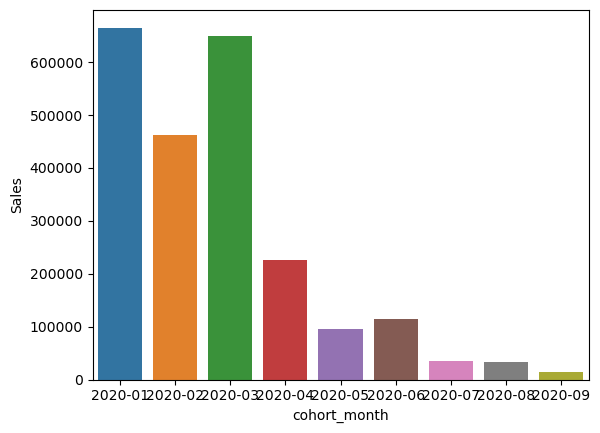

In [39]:
sb.barplot(data=saas.sort_values(by='cohort_month'),x='cohort_month',y='Sales',estimator='sum',errorbar=('ci', False))

Dari tabel dan grafik di atas diketahui bahwa cohort Januari dan Maret 2020 memiliki jumlah transaksi lebih besar daripada cohort lainnya, yaitu di atas 600 ribu dollar. Terdapat penurunan signifikan pada cohort-cohort berikutnya 

#### Churn

Selanjutnya kita akan menyelidiki, kapan user mulai berhenti membeli? Hal ini bisa dilihat dari persentase churn bulanan. 
Pertama-tama, cari total pembelian per bulan serta bulan ke-n sejak pembelian pertama untuk setiap customer

In [40]:
grouped1=saas.copy()
grouped1['current_order_month']=grouped1['current_order_month'].dt.to_timestamp()
grouped1 = grouped1.groupby(['Customer','Industry']).resample('M',on='current_order_month').agg({
    'Sales':'sum',
    'period_number':'median',
    'Discount':'mean'

}).replace(np.nan, 0)
grouped1.reset_index(drop=False,inplace=True)
grouped1['month']=grouped1['current_order_month'].dt.month
grouped1

,Customer,Industry,current_order_month,Sales,period_number,Discount,month
0,AT&T,Communications,2020-03-31,21.920,0.0,0.000000,3
1,AT&T,Communications,2020-04-30,18.900,1.0,0.000000,4
2,AT&T,Communications,2020-05-31,0.000,0.0,0.000000,5
3,AT&T,Communications,2020-06-30,0.000,0.0,0.000000,6
4,AT&T,Communications,2020-07-31,0.000,0.0,0.000000,7
...,...,...,...,...,...,...,...
4525,Wells Fargo,Finance,2023-08-31,292.120,43.0,0.166667,8
4526,Wells Fargo,Finance,2023-09-30,7359.918,44.0,0.042857,9
4527,Wells Fargo,Finance,2023-10-31,681.910,45.0,0.000000,10
4528,Wells Fargo,Finance,2023-11-30,265.408,46.0,0.200000,11


Kemudian dapatkan jumlah pembelian customer tersebut pada bulan sebelumnya

In [41]:
grouped1['previous_month_sales'] = grouped1.groupby('Customer')['Sales'].shift(1)
grouped1['previous_month_sales'].fillna(0, inplace=True)
grouped1

,Customer,Industry,current_order_month,Sales,period_number,Discount,month,previous_month_sales
0,AT&T,Communications,2020-03-31,21.920,0.0,0.000000,3,0.000
1,AT&T,Communications,2020-04-30,18.900,1.0,0.000000,4,21.920
2,AT&T,Communications,2020-05-31,0.000,0.0,0.000000,5,18.900
3,AT&T,Communications,2020-06-30,0.000,0.0,0.000000,6,0.000
4,AT&T,Communications,2020-07-31,0.000,0.0,0.000000,7,0.000
...,...,...,...,...,...,...,...,...
4525,Wells Fargo,Finance,2023-08-31,292.120,43.0,0.166667,8,807.898
4526,Wells Fargo,Finance,2023-09-30,7359.918,44.0,0.042857,9,292.120
4527,Wells Fargo,Finance,2023-10-31,681.910,45.0,0.000000,10,7359.918
4528,Wells Fargo,Finance,2023-11-30,265.408,46.0,0.200000,11,681.910


Churn didefinisikan saat setiap pelanggan yang bulan sebelumnya membeli tidak membeli di bulan tertentu

In [42]:

grouped1_=grouped1.sort_values('current_order_month')
grouped1_.loc[(grouped1_['previous_month_sales']>0)&(grouped1_['Sales']==0),'Churn']=1
# grouped1_.loc[(grouped1_['previous_month_sales']>0)&(grouped1_['Sales']>grouped1_['previous_month_sales']),'Expand']=1
# grouped1_.loc[(grouped1_['previous_month_sales']>0)&(grouped1_['Sales']<grouped1_['previous_month_sales']),'Contract']=1
# grouped1_.loc[(grouped1_['previous_month_sales']>0)&(grouped1_['Sales']==grouped1_['previous_month_sales']),'Stable']=1
# grouped1_.loc[(grouped1_['Sales']>0)&(grouped1_['period_number']==0),'New']=1
grouped1_.loc[(grouped1_['Discount']>0),'Discounted']=1

grouped1_.fillna(0,inplace=True)
grouped1_

,Customer,Industry,current_order_month,Sales,period_number,Discount,month,previous_month_sales,Churn,Discounted
1564,Engie,Energy,2020-01-31,103.524,0.0,0.066667,1,0.000,0.0,1.0
4482,Wells Fargo,Finance,2020-01-31,9.940,0.0,0.000000,1,0.000,0.0,0.0
2432,Johnson & Johnson,Healthcare,2020-01-31,25.248,0.0,0.200000,1,0.000,0.0,1.0
2480,Kroger,Retail,2020-01-31,426.670,0.0,0.066667,1,0.000,0.0,1.0
2528,Lowes,Retail,2020-01-31,1859.400,0.0,0.000000,1,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1116,Chevron,Energy,2023-12-31,1441.174,46.0,0.100000,12,278.120,0.0,1.0
2387,Itochu,Finance,2023-12-31,125.980,46.0,0.575000,12,1796.316,0.0,1.0
2340,Intel,Tech,2023-12-31,67.952,45.0,0.133333,12,0.000,0.0,1.0
184,Airbus,Manufacturing,2023-12-31,47.992,47.0,0.200000,12,3676.766,0.0,1.0


In [43]:
grouped1__=grouped1_[grouped1_['Sales']!=0].groupby('current_order_month').agg({
    'Customer':'nunique'
})
grouped1__['Prev_Cust']=grouped1__['Customer'].shift(1)
grouped1__.fillna(0,inplace=True)


grouped1___=grouped1_.groupby('current_order_month').agg({
    'Churn':'sum',
    'Sales':'sum'
})

In [44]:
saas_churn=pd.concat([grouped1__,grouped1___],axis=1)
saas_churn['churn_rate']=100*saas_churn['Churn']/saas_churn['Prev_Cust']
saas_churn['churn_rate'].fillna(0,inplace=True)
saas_churn.reset_index(drop=False,inplace=True)
saas_churn.head(5)

,current_order_month,Customer,Prev_Cust,Churn,Sales,churn_rate
0,2020-01-31,27,0.0,0.0,13946.229,0.000000
1,2020-02-29,27,27.0,18.0,4810.558,66.666667
2,2020-03-31,44,27.0,18.0,55691.009,66.666667
3,2020-04-30,44,44.0,21.0,28295.345,47.727273
4,2020-05-31,46,44.0,23.0,23648.287,52.272727


<Axes: xlabel='current_order_month', ylabel='churn_rate'>

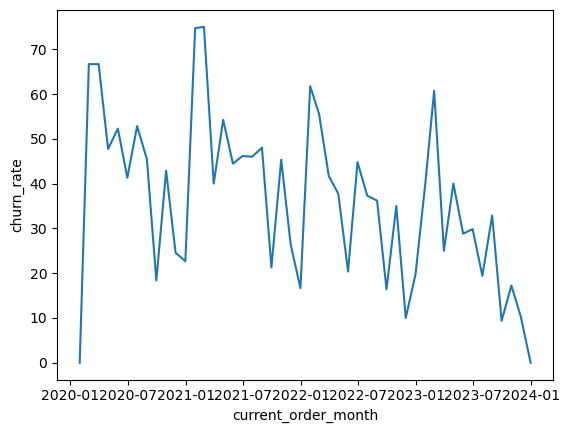

In [45]:
sb.lineplot(data=saas_churn,x='current_order_month',y='churn_rate')

Kita telah mendapatkan grafik persentase jumlah pelanggan yang churn terhadap jumlah pelanggan pada bulan sebelumnya

Berdasarkan grafik di atas, terlihat suatu pola, yaitu persentase churn yang meningkat drastis setiap bulan Februari-Januari, namun terus berkurang sepanjang tahun. 
Secara umum, Churn rate mengalami tren penurunan dari 2020 hingga 2024. Pada puncak churn bulan Januari 2023 hanya 60% persen, dibandingkan pada Febrari 2021 yang di atas 70%



#### Kerugian dan Diskon
Selanjutnya mari lihat jumlah penjualan berdasarkan ada tidaknya diskon

<Axes: xlabel='month', ylabel='Sales'>

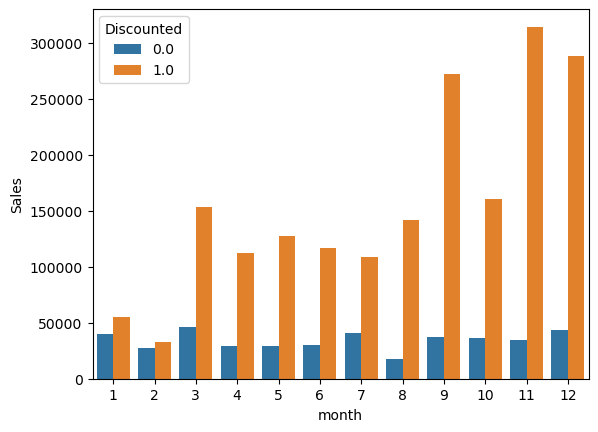

In [46]:
sb.barplot(data=grouped1_,x='month',y='Sales',hue='Discounted',estimator='sum',errorbar=('ci', False))

In [77]:
from scipy.stats import kruskal

group=[saas[saas['Discount'] == i]['Profit'].values for i in saas['Discount'].unique()]
_,pvalue=kruskal(*group)
pvalue

print(f'p-value: {pvalue}')

if pvalue > 0.05:
    print('perbedaan antar diskon yang diberikan tidak mempengaruhi profit')
else :
    print('perbedaan antar diskon yang diberikan mempengaruhi penjualan')

p-value: 0.0
perbedaan antar diskon yang diberikan mempengaruhi penjualan


Pada bulan Januari-Februari tercatat sales pada layanan yang mengalami diskon berada di titik terndah sepanjang tahun, nyaris sama dengan layanan yang tidak didiskon. Sebaliknya pada September-Oktober, penjualan meningkat drastis, dan sebagian besar didukung oleh produk yang sedang didiskon. Penjualan produk tanpa diskon relatif konstan sepanjang tahun

Hal ini menunjukkan pelanggan SaaS cukup sensitif pada keberadaan diskon, sehingga menghindari membayar pada bulan Januari-Februari

Didukung pula dengan pengujian Kruskal Wallis, terdapat perbedaan antara revenue yang dihasilkan pada masing-masing level diskon. Kita akan investigasi lebih lanjut dengan boxplot untuk melihat median revenue pada masing-masing level diskon



Text(0.5, 0, 'Profit (percent)')

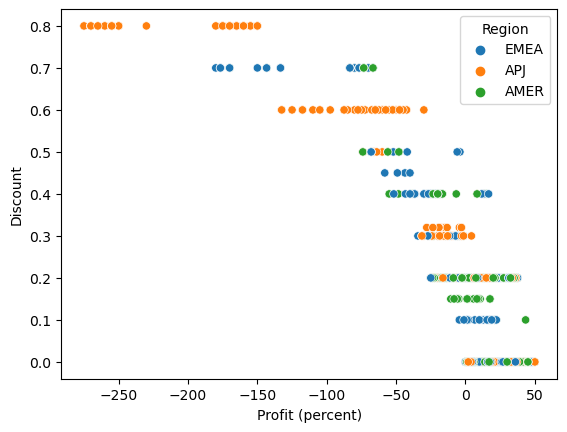

In [64]:
sb.scatterplot(data=saas[saas['year']==2023],x=100*saas['Profit']/saas['Sales'],hue='Region',y='Discount')
plt.xlabel('Profit (percent)')

Terindikais bahwa pada produk yang diberikan diskon terbesar penjualannya cenderung menghasilkan profit negatif. Bila dilihat berdasarkan persebaran region, produk yang rugi ini muncul dari penjualan di Asia Pasifik, dengan sebagian dari region lainnya. Selanjutnya kita akan lihat produk mana yang berkontribusi pada kerugian ini

<Axes: xlabel='Region'>

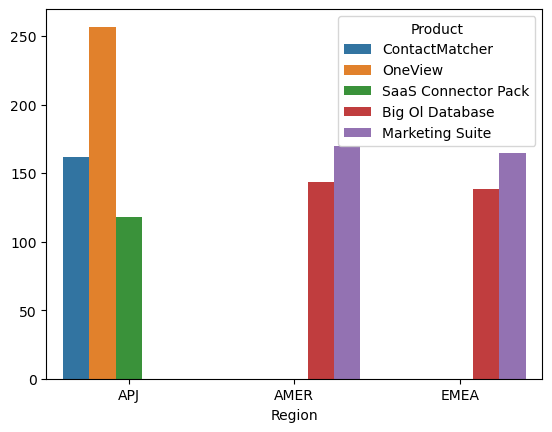

In [75]:
sb.barplot(data=saas[((100*saas['Profit']/saas['Sales'])<=-100)&(saas['year']==2023)],x='Region',y=-100*saas['Profit']/saas['Sales'],hue='Product',estimator='mean',errorbar=('ci', False))


Text(0, 0.5, 'Loss')

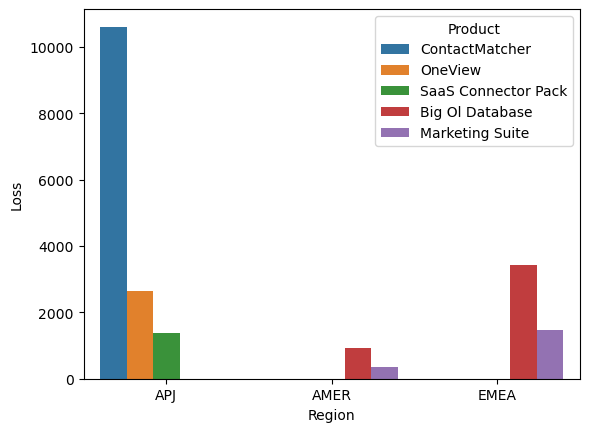

In [80]:
sb.barplot(data=saas[((100*saas['Profit']/saas['Sales'])<=-100)&(saas['year']==2023)],x='Region',y=-saas['Profit'],hue='Product',estimator='sum',errorbar=('ci', False))
plt.ylabel('Loss')

Kedua grafik di atas menunjukkan produk yang berkontribusi pada kerugian, baik dari  persentase relatif terhadap penjualan maupun nominal kerugian sendiri. Di Asia Pasifik, Contact Matcher mencatatkan kerugian terbesar, namun dari segi persentase OneView merugi lebih besar relatif terhadap penjualan. Sementara itu di region  Amerika dan region Eropa-Afrika, Big Ol dan Maketing Suite memberikan kerugian terbesar



#### Lifetime Value
Setelah sebelumnya mengetahui churn rate, kita dapat memperkirakan Lilfetime Value dari seluruh konsumen pada periode tertentu. CLV diperkirakan dari perkiraan lama bertahan berlangganan yang didapatkan dair rumus

Attrition months = 1/churn rate

Kemudian CLV didapatkan dengan mengalikan attrition months dengan jumlah sales pada bulan tersebut

<Axes: xlabel='current_order_month', ylabel='CLV'>

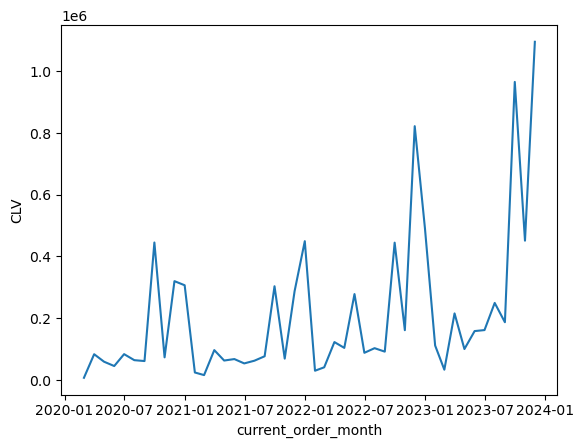

In [49]:
saas_churn['average_lifetime']=1/(saas_churn['churn_rate']/100)
saas_churn['CLV']=saas_churn['Sales']*saas_churn['average_lifetime']
sb.lineplot(data=saas_churn,x='current_order_month',y='CLV')


<Axes: xlabel='current_order_month', ylabel='average_lifetime'>

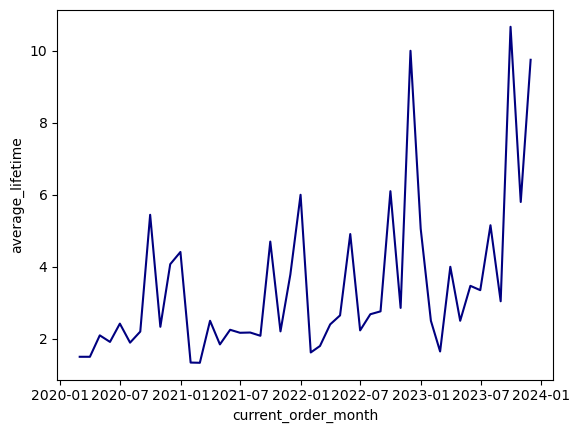

In [50]:
sb.lineplot(data=saas_churn,x='current_order_month',y='average_lifetime',color='navy')

Dari diagram di atas, terlihat bahwa durasi rata-rata pelanggan bertahan meningkat pada setiap akhir tahun. Hingga pada 2024, tercatat pelanggan rata-rata bertahan selama 10 bulan. 

### Kesimpulan dan Rekomendasi

Berdasarkan analisis yang kita telah lakukan, terdapat beberap kesimpulan, yaitu:
* Puncak rata-rata usia berlangganan meningkat dari 5 bulan pada tahun 2020 sampai 10 bulan pada tahun 2023
* Tingkat churn pelanggan tinggi pada setiap bulan Januari dan Februari
* Pendapatan didominasi dari transaksi yang mendapatkan diskon
* Pelanggan yang pertama kali berlangganan di tiga bulan pertama dibukanya platform cenderung bertransaksi lebih banyak dan lebih setia dari pelanggan yang bergabung kemudian


**Rekomendasi** 
1. Untuk meningkatkan penjualan di awal tahun, perlu memberikan alternatif plan yang lebih murah bagi pelanggan yang akan berlangganan 
2. Memberikan fokus pada pelanggan lama agar tetap setia berlangganan.
3. Berhati-hati dalam memberikan diskon pada pelanggan. Perlu lakukan evaluasi pada produk yang merugi terus meskioun telah diberikan diskon yang besar di semua region.
